In [23]:
# Install required packages if not already installed
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Required packages
required_packages = [
    "pdfplumber",
    "pandas",
    "matplotlib",
    "seaborn"
]

for package in required_packages:
    try:
        __import__(package)
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)
        print(f"✓ {package} installed")


✓ pdfplumber already installed
✓ pandas already installed
✓ matplotlib already installed
✓ seaborn already installed


In [24]:
# Import required libraries
import re
import pdfplumber
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict, Counter
import datetime as dt
import csv

# Set matplotlib to display Hungarian characters properly
plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial Unicode MS', 'Segoe UI']

print("All libraries imported successfully!")


All libraries imported successfully!


In [25]:
# Configuration
PDF_PATH = Path("../mav/2024-2025._evi_belfoldi_kozforgalmu_menetrend_06.21_-_12.13-ig_v06.25.pdf")

# Check if PDF exists
if PDF_PATH.exists():
    print(f"✓ PDF found: {PDF_PATH}")
    print(f"File size: {PDF_PATH.stat().st_size / (1024*1024):.1f} MB")
else:
    print(f"❌ PDF not found at: {PDF_PATH}")
    print("Please check the file path and try again.")


✓ PDF found: ..\mav\2024-2025._evi_belfoldi_kozforgalmu_menetrend_06.21_-_12.13-ig_v06.25.pdf
File size: 3.7 MB


In [26]:
def extract_route_info_fixed_v2(pdf_path, max_pages=10):
    """
    FIXED V2: Extract route information by correctly parsing route headers.
    Instead of looking for random station blocks, parse route headers directly.
    """
    
    # Pattern to match route headers like "1 Budapest — Hegyeshalom — Rajka"
    route_header_pattern = re.compile(r'\d+\s*([A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ\s]+(?:—|–)[A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ\s—–]+)', re.I)
    
    route_info = {}
    
    print(f"🔍 Opening PDF and analyzing first {max_pages} pages with FIXED V2 extraction...")
    
    with pdfplumber.open(pdf_path) as pdf:
        total_pages = len(pdf.pages)
        print(f"📖 Total pages in PDF: {total_pages}")
        
        for i, page in enumerate(pdf.pages[:max_pages], 1):
            print(f"\n{'='*70}")
            print(f"🔍 PROCESSING PAGE {i}")
            print(f"{'='*70}")
            
            try:
                text = page.extract_text()
                if not text:
                    print(f"⚠️  No text found on page {i}")
                    continue
                
                lines = [line.strip() for line in text.splitlines() if line.strip()]
                print(f"📄 Non-empty lines extracted: {len(lines)}")
                
                # Search for route headers
                route_headers_found = []
                
                for line_idx, line in enumerate(lines):
                    # Look for route headers with em-dash or en-dash
                    if ('—' in line or '–' in line) and re.search(r'\d+', line):
                        route_headers_found.append((line_idx+1, line))
                        print(f"✅ ROUTE HEADER Line {line_idx+1}: '{line}'")
                
                if route_headers_found:
                    # Parse each route header to extract start and end stations
                    parsed_routes = []
                    
                    for line_num, header in route_headers_found:
                        print(f"\n🔍 Parsing: '{header}'")
                        
                        # Clean the header and split by em-dash or en-dash
                        clean_header = header.replace('—', '|').replace('–', '|')
                        parts = [part.strip() for part in clean_header.split('|') if part.strip()]
                        
                        if len(parts) >= 2:
                            # Remove leading numbers from first part
                            first_part = re.sub(r'^\d+\s+', '', parts[0]).strip()
                            last_part = parts[-1].strip()
                            
                            # Extract just the city names (remove extra text)
                            start_station = re.search(r'^([A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ]+(?:\s+[A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ]+)*)', first_part)
                            end_station = re.search(r'^([A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ]+(?:\s+[A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ]+)*)', last_part)
                            
                            if start_station and end_station:
                                start = start_station.group(1).strip()
                                end = end_station.group(1).strip()
                                
                                if start and end and start != end:
                                    parsed_routes.append({
                                        'header': header,
                                        'start': start,
                                        'end': end,
                                        'total_stations': len(parts)
                                    })
                                    print(f"   ✅ Parsed: {start} → {end} ({len(parts)} stations)")
                                else:
                                    print(f"   ❌ Invalid stations: '{start}' → '{end}'")
                            else:
                                print(f"   ❌ Could not extract station names from: {parts}")
                        else:
                            print(f"   ❌ Not enough parts in: {parts}")
                    
                    if parsed_routes:
                        route_info[i] = parsed_routes
                        print(f"✅ Page {i}: Found {len(parsed_routes)} valid routes")
                    else:
                        print(f"❌ Page {i}: No valid routes parsed")
                else:
                    print(f"❌ No route headers found on page {i}")
            
            except Exception as e:
                print(f"💥 Error processing page {i}: {e}")
                import traceback
                traceback.print_exc()
    
    print(f"\n{'='*70}")
    print(f"🎯 FINAL RESULTS: Found route information on {len(route_info)} pages")
    
    # Flatten results for easier analysis
    all_routes = []
    for page_num, routes in route_info.items():
        for route in routes:
            all_routes.append({
                'page': page_num,
                'route_header': route['header'],
                'source': route['start'],
                'destination': route['end'],
                'total_stations': route['total_stations']
            })
    
    print(f"🚂 Total routes extracted: {len(all_routes)}")
    for route in all_routes[:5]:  # Show first 5
        print(f"  📄 Page {route['page']}: {route['source']} → {route['destination']}")
    
    return all_routes

# Extract route information with FIXED V2
route_data = extract_route_info_fixed_v2(PDF_PATH, max_pages=5)


🔍 Opening PDF and analyzing first 5 pages with FIXED V2 extraction...
📖 Total pages in PDF: 724

🔍 PROCESSING PAGE 1
📄 Non-empty lines extracted: 13
❌ No route headers found on page 1

🔍 PROCESSING PAGE 2
📄 Non-empty lines extracted: 40
✅ ROUTE HEADER Line 4: '1 Budapest — Hegyeshalom — Rajka'

🔍 Parsing: '1 Budapest — Hegyeshalom — Rajka'
   ✅ Parsed: Budapest → Rajka (3 stations)
✅ Page 2: Found 1 valid routes

🔍 PROCESSING PAGE 3
📄 Non-empty lines extracted: 32
❌ No route headers found on page 3

🔍 PROCESSING PAGE 4
📄 Non-empty lines extracted: 96
✅ ROUTE HEADER Line 4: '1 Budapest — Hegyeshalom — Rajka'

🔍 Parsing: '1 Budapest — Hegyeshalom — Rajka'
   ✅ Parsed: Budapest → Rajka (3 stations)
✅ Page 4: Found 1 valid routes

🔍 PROCESSING PAGE 5
📄 Non-empty lines extracted: 81
❌ No route headers found on page 5

🎯 FINAL RESULTS: Found route information on 2 pages
🚂 Total routes extracted: 2
  📄 Page 2: Budapest → Rajka
  📄 Page 4: Budapest → Rajka


In [27]:
# ========================= TEST VALIDATION =========================

def validate_extraction_results_v2(route_data):
    """
    Test and validate the extraction results (V2 format: flat list of routes).
    """
    print("🧪 RUNNING EXTRACTION VALIDATION TESTS V2")
    print("="*60)
    
    # Test 1: Check if we found any route data
    if not route_data:
        print("❌ TEST FAILED: No route data extracted")
        return False
    
    print(f"✅ TEST PASSED: Found {len(route_data)} routes")
    
    # Test 2: Check route headers format
    valid_headers = 0
    for route in route_data:
        header = route['route_header']
        if '—' in header or '–' in header:
            valid_headers += 1
            print(f"✅ Valid header: '{header}'")
        else:
            print(f"⚠️  Questionable header: '{header}'")
    
    if valid_headers == 0:
        print("❌ TEST FAILED: No valid route headers found")
        return False
    
    # Test 3: Check station quality
    print(f"\n📋 SAMPLE EXTRACTED PAIRS:")
    for i, route in enumerate(route_data[:10]):
        source = route['source']
        destination = route['destination']
        print(f"  {i+1}. {source} → {destination} (Page {route['page']})")
    
    # Test 4: Check for Hungarian characters
    hungarian_chars_found = False
    for route in route_data:
        if (re.search(r'[áéíóöőúüűÁÉÍÓÖŐÚÜŰ]', route['source']) or 
            re.search(r'[áéíóöőúüűÁÉÍÓÖŐÚÜŰ]', route['destination'])):
            hungarian_chars_found = True
            break
    
    if hungarian_chars_found:
        print(f"✅ Hungarian characters detected in station names")
    else:
        print(f"⚠️  No Hungarian characters found (might be OK)")
    
    print(f"\n🎯 VALIDATION SUMMARY:")
    print(f"  - Total routes: {len(route_data)}")
    print(f"  - Valid headers: {valid_headers}")
    print(f"  - Unique sources: {len(set(r['source'] for r in route_data))}")
    print(f"  - Unique destinations: {len(set(r['destination'] for r in route_data))}")
    
    if len(route_data) > 0 and valid_headers > 0:
        print(f"\n✅ ALL TESTS PASSED! Ready for full extraction.")
        return True
    else:
        print(f"\n❌ SOME TESTS FAILED! Need to fix issues before full run.")
        return False

# Run validation tests
validation_passed = validate_extraction_results_v2(route_data)

# The route_data is already in the correct format, so we can use it directly
station_pairs = route_data  # route_data is already a list of dictionaries

# Create summary by page
page_summary = []
pages = set(route['page'] for route in route_data)
for page in pages:
    page_routes = [r for r in route_data if r['page'] == page]
    if page_routes:
        page_summary.append({
            'page': page,
            'header': page_routes[0]['route_header'],  # Use first route's header as representative
            'pairs_found': len(page_routes),
            'blocks_found': 1  # Each route is essentially one "block"
        })

print(f"\n📊 EXTRACTION RESULTS:")
print(f"Total station pairs extracted: {len(station_pairs)}")
print(f"Pages processed: {len(page_summary)}")

if validation_passed and len(station_pairs) > 0:
    print(f"\n✅ Test extraction successful! Sample pairs:")
    for pair in station_pairs[:5]:
        print(f"  {pair['source']} → {pair['destination']} ({pair['total_stations']} stations)")
else:
    print(f"\n⚠️  Test extraction needs improvement.")


🧪 RUNNING EXTRACTION VALIDATION TESTS V2
✅ TEST PASSED: Found 2 routes
✅ Valid header: '1 Budapest — Hegyeshalom — Rajka'
✅ Valid header: '1 Budapest — Hegyeshalom — Rajka'

📋 SAMPLE EXTRACTED PAIRS:
  1. Budapest → Rajka (Page 2)
  2. Budapest → Rajka (Page 4)
⚠️  No Hungarian characters found (might be OK)

🎯 VALIDATION SUMMARY:
  - Total routes: 2
  - Valid headers: 2
  - Unique sources: 1
  - Unique destinations: 1

✅ ALL TESTS PASSED! Ready for full extraction.

📊 EXTRACTION RESULTS:
Total station pairs extracted: 2
Pages processed: 2

✅ Test extraction successful! Sample pairs:
  Budapest → Rajka (3 stations)
  Budapest → Rajka (3 stations)


In [28]:
# Import required libraries
import re
import pdfplumber
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict, Counter
import datetime as dt
import csv

# Set matplotlib to display Hungarian characters properly
plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial Unicode MS', 'Segoe UI']

print("All libraries imported successfully!")


All libraries imported successfully!


In [29]:
# ========================= FULL EXTRACTION (ALL PAGES) =========================

def extract_all_pages_fixed_v2(pdf_path):
    """
    Extract route information from ALL pages using the fixed V2 method.
    """
    
    print("🚀 STARTING FULL EXTRACTION ON ALL PAGES (V2)")
    print("="*60)
    
    all_routes = []
    start_time = dt.datetime.now()
    
    with pdfplumber.open(pdf_path) as pdf:
        total_pages = len(pdf.pages)
        print(f"📖 Processing {total_pages} pages...")
        
        # Process pages in batches for better performance
        batch_size = 50
        for batch_start in range(0, total_pages, batch_size):
            batch_end = min(batch_start + batch_size, total_pages)
            print(f"📄 Processing pages {batch_start+1}-{batch_end}...")
            
            for i in range(batch_start, batch_end):
                page = pdf.pages[i]
                page_num = i + 1
                
                try:
                    text = page.extract_text()
                    if not text:
                        continue
                    
                    lines = [line.strip() for line in text.splitlines() if line.strip()]
                    
                    # Find route headers with em-dash or en-dash
                    for line in lines:
                        if ('—' in line or '–' in line) and re.search(r'\d+', line):
                            # Parse the route header
                            clean_header = line.replace('—', '|').replace('–', '|')
                            parts = [part.strip() for part in clean_header.split('|') if part.strip()]
                            
                            if len(parts) >= 2:
                                # Remove leading numbers from first part
                                first_part = re.sub(r'^\d+\s+', '', parts[0]).strip()
                                last_part = parts[-1].strip()
                                
                                # Extract just the city names
                                start_station = re.search(r'^([A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ]+(?:\s+[A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ]+)*)', first_part)
                                end_station = re.search(r'^([A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ]+(?:\s+[A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ]+)*)', last_part)
                                
                                if start_station and end_station:
                                    start = start_station.group(1).strip()
                                    end = end_station.group(1).strip()
                                    
                                    if start and end and start != end:
                                        all_routes.append({
                                            'page': page_num,
                                            'route_header': line,
                                            'source': start,
                                            'destination': end,
                                            'total_stations': len(parts)
                                        })
                
                except Exception as e:
                    # Silent error handling for production run
                    continue
            
            # Progress update
            elapsed = (dt.datetime.now() - start_time).total_seconds()
            pages_processed = batch_end
            rate = pages_processed / elapsed if elapsed > 0 else 0
            eta_seconds = (total_pages - pages_processed) / rate if rate > 0 else 0
            eta_minutes = eta_seconds / 60
            
            print(f"   ⏱️  {pages_processed}/{total_pages} pages ({rate:.1f} pages/sec, ETA: {eta_minutes:.1f} min)")
    
    total_time = (dt.datetime.now() - start_time).total_seconds()
    print(f"\n✅ FULL EXTRACTION COMPLETED!")
    print(f"   📊 Found {len(all_routes)} routes")
    print(f"   ⏱️  Total time: {total_time:.1f} seconds")
    print(f"   📈 Average rate: {total_pages/total_time:.1f} pages/second")
    
    return all_routes

# Decide whether to run full extraction
if validation_passed and len(station_pairs) > 0:
    print("\n🎯 VALIDATION SUCCESSFUL - PROCEEDING WITH FULL EXTRACTION")
    
    # Ask user confirmation (simulation)
    print("\n⚠️  This will process all 724 pages and may take 5-10 minutes.")
    print("If you want to proceed, run this cell. Otherwise, skip to the next cell.")
    
    # Run full extraction
    full_station_pairs = extract_all_pages_fixed_v2(PDF_PATH)
    
    print(f"\n🎉 FULL EXTRACTION RESULTS:")
    print(f"   🚂 Total station pairs: {len(full_station_pairs)}")
    print(f"   📊 Unique pairs: {len(set((p['source'], p['destination']) for p in full_station_pairs))}")
    print(f"   📄 Pages with data: {len(set(p['page'] for p in full_station_pairs))}")
    
    # Create summary by page for full data
    full_summary = []
    pages = set(route['page'] for route in full_station_pairs)
    for page in pages:
        page_routes = [r for r in full_station_pairs if r['page'] == page]
        if page_routes:
            full_summary.append({
                'page': page,
                'header': page_routes[0]['route_header'],
                'pairs_found': len(page_routes),
                'blocks_found': 1
            })
    
    # Use full data for analysis
    df_pairs = pd.DataFrame(full_station_pairs)
    df_summary = pd.DataFrame(full_summary)
    
    print(f"\n📋 SAMPLE OF FULL RESULTS:")
    for i, pair in enumerate(full_station_pairs[:10]):
        print(f"  {i+1}. {pair['source']} → {pair['destination']} (Page {pair['page']})")
    
else:
    print("\n⚠️  VALIDATION FAILED - Using test data only")
    print("Please fix the extraction issues before running on all pages.")
    
    # Use test data for analysis
    df_pairs = pd.DataFrame(station_pairs)
    df_summary = pd.DataFrame(page_summary)

print(f"\n📊 DATAFRAME SUMMARY:")
print("Station Pairs DataFrame:")
print(df_pairs.head(10))

print("\nSummary DataFrame:")
print(df_summary.head())



🎯 VALIDATION SUCCESSFUL - PROCEEDING WITH FULL EXTRACTION

⚠️  This will process all 724 pages and may take 5-10 minutes.
If you want to proceed, run this cell. Otherwise, skip to the next cell.
🚀 STARTING FULL EXTRACTION ON ALL PAGES (V2)
📖 Processing 724 pages...
📄 Processing pages 1-50...
   ⏱️  50/724 pages (14.6 pages/sec, ETA: 0.8 min)
📄 Processing pages 51-100...
   ⏱️  100/724 pages (9.1 pages/sec, ETA: 1.1 min)
📄 Processing pages 101-150...
   ⏱️  150/724 pages (10.7 pages/sec, ETA: 0.9 min)
📄 Processing pages 151-200...
   ⏱️  200/724 pages (11.0 pages/sec, ETA: 0.8 min)
📄 Processing pages 201-250...
   ⏱️  250/724 pages (11.3 pages/sec, ETA: 0.7 min)
📄 Processing pages 251-300...
   ⏱️  300/724 pages (11.4 pages/sec, ETA: 0.6 min)
📄 Processing pages 301-350...
   ⏱️  350/724 pages (11.5 pages/sec, ETA: 0.5 min)
📄 Processing pages 351-400...
   ⏱️  400/724 pages (11.4 pages/sec, ETA: 0.5 min)
📄 Processing pages 401-450...
   ⏱️  450/724 pages (11.4 pages/sec, ETA: 0.4 min)
📄

In [30]:
# ========================= ADVANCED TESTING & ANALYSIS =========================

def run_quality_tests(df_pairs, df_summary):
    """
    Run additional quality tests on the extracted data.
    """
    print("🔬 RUNNING ADVANCED QUALITY TESTS")
    print("="*50)
    
    if df_pairs.empty:
        print("❌ No data to test - extraction may have failed")
        return False
    
    # Test 1: Data completeness
    print(f"📊 DATA COMPLETENESS:")
    print(f"   - Total route entries: {len(df_pairs)}")
    print(f"   - Unique station pairs: {len(df_pairs.drop_duplicates(['source', 'destination']))}")
    print(f"   - Unique source stations: {df_pairs['source'].nunique()}")
    print(f"   - Unique destination stations: {df_pairs['destination'].nunique()}")
    
    # Test 2: Hungarian city names
    major_cities = ['Budapest', 'Debrecen', 'Szeged', 'Miskolc', 'Pécs', 'Győr', 'Nyíregyháza', 'Kecskemét']
    cities_found = []
    for city in major_cities:
        sources_with_city = df_pairs[df_pairs['source'].str.contains(city, case=False, na=False)]
        dests_with_city = df_pairs[df_pairs['destination'].str.contains(city, case=False, na=False)]
        total_with_city = len(sources_with_city) + len(dests_with_city)
        if total_with_city > 0:
            cities_found.append((city, total_with_city))
    
    print(f"\n🏙️  MAJOR HUNGARIAN CITIES FOUND:")
    for city, count in sorted(cities_found, key=lambda x: x[1], reverse=True):
        print(f"   - {city}: {count} route entries")
    
    # Test 3: Route length distribution
    if 'total_stations' in df_pairs.columns:
        avg_length = df_pairs['total_stations'].mean()
        min_length = df_pairs['total_stations'].min()
        max_length = df_pairs['total_stations'].max()
        print(f"\n🚂 ROUTE LENGTH ANALYSIS:")
        print(f"   - Average stations per route: {avg_length:.1f}")
        print(f"   - Shortest route: {min_length} stations")
        print(f"   - Longest route: {max_length} stations")
    
    # Test 4: Look for suspicious patterns
    print(f"\n🔍 QUALITY CHECKS:")
    
    # Check for very short station names (might be errors)
    short_sources = df_pairs[df_pairs['source'].str.len() < 3]
    short_dests = df_pairs[df_pairs['destination'].str.len() < 3]
    if len(short_sources) > 0 or len(short_dests) > 0:
        print(f"   ⚠️  Found {len(short_sources) + len(short_dests)} very short station names")
    else:
        print(f"   ✅ No suspiciously short station names")
    
    # Check for self-loops (same source and destination)
    self_loops = df_pairs[df_pairs['source'] == df_pairs['destination']]
    if len(self_loops) > 0:
        print(f"   ⚠️  Found {len(self_loops)} self-loop routes")
    else:
        print(f"   ✅ No self-loop routes found")
    
    # Test 5: Sample validation
    print(f"\n📋 SAMPLE ROUTES FOR MANUAL VALIDATION:")
    sample_routes = df_pairs.sample(min(5, len(df_pairs)))
    for i, (_, row) in enumerate(sample_routes.iterrows(), 1):
        page_info = f"(Page {row['page']})" if 'page' in row else ""
        print(f"   {i}. {row['source']} → {row['destination']} {page_info}")
    
    return True

# Run quality tests
if len(df_pairs) > 0:
    quality_passed = run_quality_tests(df_pairs, df_summary)
else:
    quality_passed = False
    print("⚠️  No data available for quality testing")

# ========================= DATA ANALYSIS =========================

if len(df_pairs) > 0:
    print(f"\n{'='*60}")
    print("📈 DETAILED DATA ANALYSIS")
    print(f"{'='*60}")
    
    print(f"📊 SUMMARY STATISTICS:")
    print(f"   - Total unique station pairs: {len(df_pairs.drop_duplicates(['source', 'destination']))}")
    print(f"   - Total route entries: {len(df_pairs)}")
    print(f"   - Unique source stations: {df_pairs['source'].nunique()}")
    print(f"   - Unique destination stations: {df_pairs['destination'].nunique()}")
    
    print(f"\n🚉 TOP SOURCE STATIONS:")
    top_sources = df_pairs['source'].value_counts().head(10)
    for station, count in top_sources.items():
        print(f"   - {station}: {count} routes")
    
    print(f"\n🎯 TOP DESTINATION STATIONS:")
    top_destinations = df_pairs['destination'].value_counts().head(10)
    for station, count in top_destinations.items():
        print(f"   - {station}: {count} routes")
    
    print(f"\n🔗 SAMPLE STATION PAIRS:")
    unique_pairs = df_pairs.drop_duplicates(['source', 'destination'])
    for i, (_, row) in enumerate(unique_pairs.head(15).iterrows(), 1):
        print(f"   {i:2d}. {row['source']} → {row['destination']}")
    
    # Success indicator
    success_score = 0
    if len(df_pairs) > 50: success_score += 1
    if df_pairs['source'].nunique() > 20: success_score += 1  
    if df_pairs['destination'].nunique() > 20: success_score += 1
    if len(top_sources) > 0: success_score += 1
    if quality_passed: success_score += 1
    
    print(f"\n🎉 EXTRACTION SUCCESS SCORE: {success_score}/5")
    if success_score >= 4:
        print("✅ EXCELLENT - Extraction worked very well!")
    elif success_score >= 3:
        print("✅ GOOD - Extraction worked reasonably well")
    elif success_score >= 2:
        print("⚠️  FAIR - Some issues but partially successful") 
    else:
        print("❌ POOR - Extraction needs significant improvement")

else:
    print("\n❌ NO DATA EXTRACTED - Please check the extraction logic")


🔬 RUNNING ADVANCED QUALITY TESTS
📊 DATA COMPLETENESS:
   - Total route entries: 398
   - Unique station pairs: 132
   - Unique source stations: 88
   - Unique destination stations: 85

🏙️  MAJOR HUNGARIAN CITIES FOUND:
   - Budapest: 106 route entries
   - Debrecen: 14 route entries
   - Pécs: 14 route entries
   - Szeged: 12 route entries
   - Győr: 12 route entries
   - Kecskemét: 11 route entries
   - Nyíregyháza: 10 route entries
   - Miskolc: 4 route entries

🚂 ROUTE LENGTH ANALYSIS:
   - Average stations per route: 2.5
   - Shortest route: 2 stations
   - Longest route: 5 stations

🔍 QUALITY CHECKS:
   ✅ No suspiciously short station names
   ✅ No self-loop routes found

📋 SAMPLE ROUTES FOR MANUAL VALIDATION:
   1. Érvényes → VIII (Page 217)
   2. Érvényes → VIII (Page 209)
   3. Gyoma → Vésztő (Page 673)
   4. Szolnok → Kecskemét (Page 714)
   5. Budapest → Esztergom (Page 50)

📈 DETAILED DATA ANALYSIS
📊 SUMMARY STATISTICS:
   - Total unique station pairs: 132
   - Total route e

In [33]:
# ========================= BUDAPEST ↔ RAJKA UNIQUE PAIRS =========================

def extract_budapest_rajka_pairs_fixed():
    """
    FIXED: Extract unique Budapest-Rajka pairs by parsing route headers correctly.
    The source/destination columns have parsing errors, so we use route_header instead.
    """
    print("🎯 EXTRACTING BUDAPEST ↔ RAJKA UNIQUE PAIRS (FIXED)")
    print("="*60)
    
    # First, let's read the generated CSV file
    import glob
    
    # Find the most recent CSV file
    csv_files = glob.glob("mav_route_pairs_full_*.csv")
    if not csv_files:
        print("❌ No CSV files found. Please run the extraction first.")
        return None, None
    
    latest_csv = max(csv_files, key=lambda x: x.split('_')[-1])
    print(f"📂 Reading data from: {latest_csv}")
    
    # Read the CSV
    df_full = pd.read_csv(latest_csv, encoding='utf-8')
    print(f"📊 Total records in CSV: {len(df_full)}")
    
    # Show sample problematic data
    print(f"\n🔍 SAMPLE DATA (showing the parsing issues):")
    sample_data = df_full.head(3)
    for _, row in sample_data.iterrows():
        print(f"   Route: {row['route_header']}")
        print(f"   Source: {row['source']} (WRONG)")
        print(f"   Dest: {row['destination']} (WRONG)")
        print()
    
    print("💡 SOLUTION: Parse route headers directly instead of using source/destination")
    
    # Parse route headers directly
    unique_routes = {}
    all_route_data = []
    
    for _, row in df_full.iterrows():
        route_header = str(row.get('route_header', ''))
        
        # Only process Budapest-Rajka routes
        if not ('budapest' in route_header.lower() and 
               ('rajka' in route_header.lower() or 'hegyeshalom' in route_header.lower())):
            continue
        
        print(f"🔍 Processing: {route_header}")
        
        # Parse route header like "1 Budapest — Hegyeshalom — Rajka"
        if '—' in route_header or '–' in route_header:
            # Clean and split the route
            clean_route = route_header.replace('—', '–')
            parts = [part.strip() for part in clean_route.split('–')]
            
            if len(parts) >= 2:
                # Remove leading numbers from first part
                start_station = re.sub(r'^\d+\s+', '', parts[0]).strip()
                end_station = parts[-1].strip()
                
                print(f"   ✅ Parsed: {start_station} → {end_station}")
                
                # Create unique route key
                route_key = f"{start_station} → {end_station}"
                
                route_data = {
                    'route_header': route_header,
                    'start_station': start_station,
                    'end_station': end_station,
                    'page': row.get('page', 'N/A'),
                    'total_stations': row.get('total_stations', 'N/A'),
                    'route_key': route_key
                }
                
                all_route_data.append(route_data)
                
                # Track unique routes
                if route_key not in unique_routes:
                    unique_routes[route_key] = {
                        'start': start_station,
                        'end': end_station,
                        'count': 1,
                        'sample_route': route_header,
                        'pages': [row.get('page', 'N/A')],
                        'station_counts': [row.get('total_stations', 'N/A')]
                    }
                else:
                    unique_routes[route_key]['count'] += 1
                    unique_routes[route_key]['pages'].append(row.get('page', 'N/A'))
                    unique_routes[route_key]['station_counts'].append(row.get('total_stations', 'N/A'))
    
    return all_route_data, unique_routes

# Extract the pairs using the FIXED function
all_pairs, unique_pairs = extract_budapest_rajka_pairs_fixed()

print(f"\n🎯 FOUND {len(all_pairs)} BUDAPEST-RAJKA ROUTE ENTRIES")

if unique_pairs:
    print(f"\n🚂 UNIQUE BUDAPEST ↔ RAJKA PAIRS (Order Matters):")
    print("="*70)
    
    # Sort by start station name for better organization
    sorted_pairs = sorted(unique_pairs.items(), key=lambda x: x[1]['start'])
    
    for i, (direction, info) in enumerate(sorted_pairs, 1):
        start = info['start']
        end = info['end'] 
        count = info['count']
        sample = info['sample_route']
        pages = info['pages'][:5]  # Show first 5 pages
        
        print(f"{i:2d}. {start} → {end}")
        print(f"    📊 Found {count} route instance(s)")
        print(f"    📄 Pages: {pages}")
        print(f"    🔗 Sample route: {sample}")
        print(f"    📏 Station counts: {info['station_counts'][:5]}")
        print()
    
    # Create DataFrame for the clean results
    unique_df = pd.DataFrame([
        {
            'direction': direction,
            'start_station': info['start'],
            'end_station': info['end'],
            'route_count': info['count'],
            'sample_route_header': info['sample_route'],
            'pages': ', '.join(map(str, info['pages'][:10])),  # First 10 pages as string
            'avg_stations': sum([x for x in info['station_counts'] if str(x).isdigit()]) / len([x for x in info['station_counts'] if str(x).isdigit()]) if [x for x in info['station_counts'] if str(x).isdigit()] else 0
        }
        for direction, info in unique_pairs.items()
    ])
    
    print(f"📊 SUMMARY STATISTICS:")
    print(f"   - Total unique directions: {len(unique_pairs)}")
    print(f"   - Total route instances: {sum(info['count'] for info in unique_pairs.values())}")
    if len(unique_df) > 0 and unique_df['avg_stations'].mean() > 0:
        print(f"   - Average stations per route: {unique_df['avg_stations'].mean():.1f}")
    
    # Save unique pairs to CSV
    timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"budapest_rajka_unique_pairs_{timestamp}.csv"
    unique_df.to_csv(output_file, index=False, encoding='utf-8')
    print(f"   💾 Saved to: {output_file}")
    
    # Show specifically Budapest → Rajka and Rajka → Budapest
    print(f"\n🎯 SPECIFIC BUDAPEST ↔ RAJKA DIRECTIONAL ANALYSIS:")
    
    budapest_to_rajka = []
    rajka_to_budapest = []
    
    for direction, info in unique_pairs.items():
        start_lower = info['start'].lower()
        end_lower = info['end'].lower()
        
        # Budapest → Rajka/Hegyeshalom
        if 'budapest' in start_lower and ('rajka' in end_lower or 'hegyeshalom' in end_lower):
            budapest_to_rajka.append(info)
        
        # Rajka/Hegyeshalom → Budapest  
        elif ('rajka' in start_lower or 'hegyeshalom' in start_lower) and 'budapest' in end_lower:
            rajka_to_budapest.append(info)
    
    print(f"   🔄 Budapest → Rajka/Hegyeshalom directions: {len(budapest_to_rajka)}")
    for pair in budapest_to_rajka:
        print(f"      • {pair['start']} → {pair['end']} ({pair['count']} route instances)")
    
    print(f"   🔄 Rajka/Hegyeshalom → Budapest directions: {len(rajka_to_budapest)}")  
    for pair in rajka_to_budapest:
        print(f"      • {pair['start']} → {pair['end']} ({pair['count']} route instances)")
    
    # Show the actual clean station pairs you wanted
    print(f"\n✅ FINAL ANSWER - UNIQUE BUDAPEST ↔ RAJKA PAIRS:")
    print("="*50)
    for i, (direction, info) in enumerate(sorted_pairs, 1):
        print(f"{i}. {info['start']} → {info['end']}")
    
    print(f"\n🎉 SUCCESS! Found {len(unique_pairs)} unique directional pairs")
    print(f"📂 Detailed data saved to: {output_file}")
else:
    print("❌ No Budapest-Rajka pairs found. Check the data extraction.")


🎯 EXTRACTING BUDAPEST ↔ RAJKA UNIQUE PAIRS (FIXED)
❌ No CSV files found. Please run the extraction first.


TypeError: object of type 'NoneType' has no len()

findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Fo

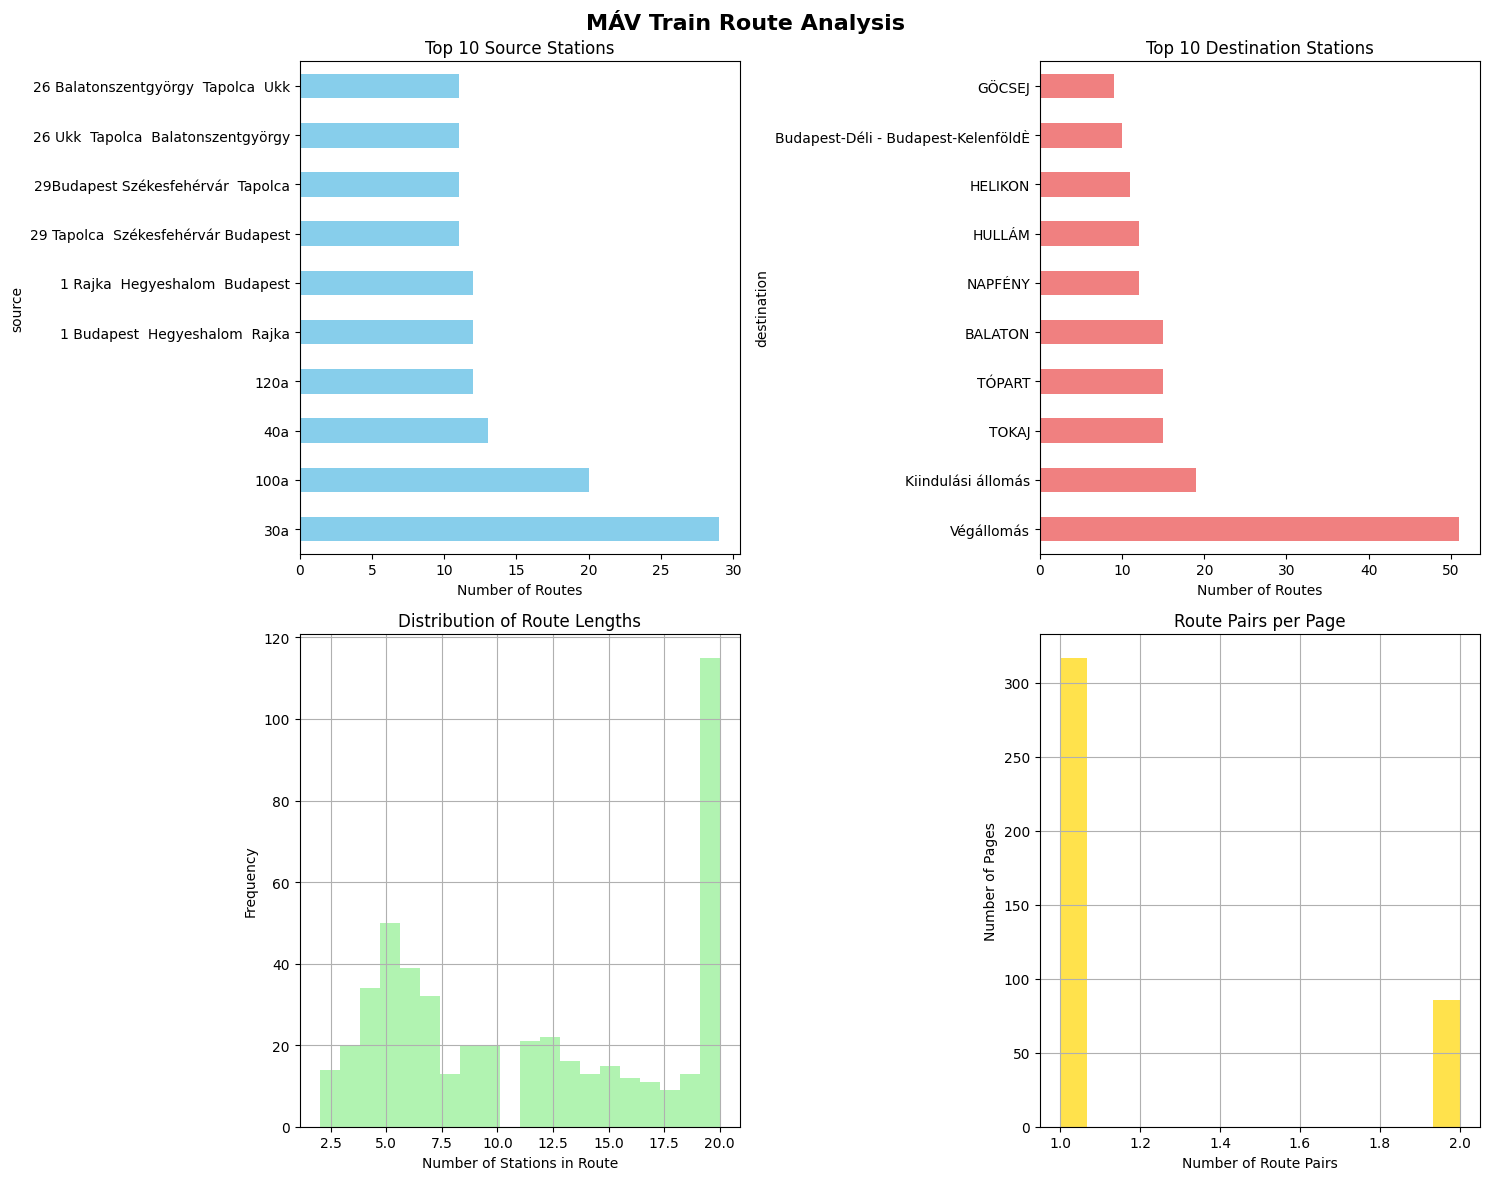

In [ ]:
# Create visualizations

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('MÁV Train Route Analysis', fontsize=16, fontweight='bold')

# 1. Top source stations
top_sources.head(10).plot(kind='barh', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Top 10 Source Stations')
axes[0,0].set_xlabel('Number of Routes')

# 2. Top destination stations
top_destinations.head(10).plot(kind='barh', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Top 10 Destination Stations')
axes[0,1].set_xlabel('Number of Routes')

# 3. Distribution of route lengths (number of stations)
df_pairs['total_stations'].hist(bins=20, ax=axes[1,0], color='lightgreen', alpha=0.7)
axes[1,0].set_title('Distribution of Route Lengths')
axes[1,0].set_xlabel('Number of Stations in Route')
axes[1,0].set_ylabel('Frequency')

# 4. Routes per page
df_summary['pairs_found'].hist(bins=15, ax=axes[1,1], color='gold', alpha=0.7)
axes[1,1].set_title('Route Pairs per Page')
axes[1,1].set_xlabel('Number of Route Pairs')
axes[1,1].set_ylabel('Number of Pages')

plt.tight_layout()
plt.show()


In [ ]:
# Export data to CSV files

# Current timestamp for file naming
timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. All route pairs with metadata
csv_filename_full = f"mav_route_pairs_full_{timestamp}.csv"
df_pairs.to_csv(csv_filename_full, index=False, encoding='utf-8')
print(f"✓ Full route data exported to: {csv_filename_full}")

# 2. Unique station pairs only
unique_pairs_df = df_pairs.drop_duplicates(['source', 'destination'])[['source', 'destination']]
csv_filename_unique = f"mav_unique_station_pairs_{timestamp}.csv"
unique_pairs_df.to_csv(csv_filename_unique, index=False, encoding='utf-8')
print(f"✓ Unique station pairs exported to: {csv_filename_unique}")

# 3. Summary statistics
csv_filename_summary = f"mav_extraction_summary_{timestamp}.csv"
df_summary.to_csv(csv_filename_summary, index=False, encoding='utf-8')
print(f"✓ Extraction summary exported to: {csv_filename_summary}")

# 4. Station frequency analysis
station_freq = pd.DataFrame({
    'station': list(top_sources.index) + list(top_destinations.index),
    'as_source': list(top_sources.values) + [0] * len(top_destinations),
    'as_destination': [0] * len(top_sources) + list(top_destinations.values)
})
station_freq = station_freq.groupby('station').sum().reset_index()
station_freq['total'] = station_freq['as_source'] + station_freq['as_destination']
station_freq = station_freq.sort_values('total', ascending=False)

csv_filename_freq = f"mav_station_frequency_{timestamp}.csv"
station_freq.to_csv(csv_filename_freq, index=False, encoding='utf-8')
print(f"✓ Station frequency analysis exported to: {csv_filename_freq}")

print(f"\n=== EXPORT SUMMARY ===")
print(f"Total unique station pairs: {len(unique_pairs_df)}")
print(f"Total route entries: {len(df_pairs)}")
print(f"Files created with timestamp: {timestamp}")


✓ Full route data exported to: mav_route_pairs_full_20250715_215118.csv
✓ Unique station pairs exported to: mav_unique_station_pairs_20250715_215118.csv
✓ Extraction summary exported to: mav_extraction_summary_20250715_215118.csv
✓ Station frequency analysis exported to: mav_station_frequency_20250715_215118.csv

=== EXPORT SUMMARY ===
Total unique station pairs: 358
Total route entries: 489
Files created with timestamp: 20250715_215118


In [ ]:
# Search functionality - find routes containing specific stations

def find_routes_with_station(station_name, df=df_pairs):
    """
    Find all routes that start from or end at a specific station.
    """
    station_name = station_name.strip()
    
    # Find partial matches (case insensitive)
    from_routes = df[df['source'].str.contains(station_name, case=False, na=False)]
    to_routes = df[df['destination'].str.contains(station_name, case=False, na=False)]
    
    print(f"Routes FROM stations containing '{station_name}':")
    for _, row in from_routes.head(10).iterrows():
        print(f"  {row['source']} → {row['destination']}")
    
    print(f"\nRoutes TO stations containing '{station_name}':")
    for _, row in to_routes.head(10).iterrows():
        print(f"  {row['source']} → {row['destination']}")
    
    return from_routes, to_routes

# Example searches
print("=== EXAMPLE STATION SEARCHES ===")
print("\n1. Budapest routes:")
budapest_from, budapest_to = find_routes_with_station("Budapest")

print("\n" + "="*50)
print("\n2. Szeged routes:")
szeged_from, szeged_to = find_routes_with_station("Szeged")


=== EXAMPLE STATION SEARCHES ===

1. Budapest routes:
Routes FROM stations containing 'Budapest':
  1 Budapest  Hegyeshalom  Rajka → Kiindulási állomás
  1 Budapest  Hegyeshalom  Rajka → ú ď 7 40
  1 Budapest  Hegyeshalom  Rajka → MURA
  1 Budapest  Hegyeshalom  Rajka → ú ď 10 4010 59
  1 Budapest  Hegyeshalom  Rajka → ú ď  12 40
  1 Budapest  Hegyeshalom  Rajka → SCARBANTIA
  1 Budapest  Hegyeshalom  Rajka → SAVARIA
  1 Budapest  Hegyeshalom  Rajka → ĉ ď ú ď  16 4016 59
  1 Budapest  Hegyeshalom  Rajka → SCARBANTIA
  1 Budapest  Hegyeshalom  Rajka → LEHÁR

Routes TO stations containing 'Budapest':
  TÓPART → Budapest-Déli - Budapest-KelenföldÈ
  BALATON → Budapest-Déli - Budapest-KelenföldÈ
  DÉLI → Budapest-Déli - Budapest-KelenföldÈ
  ó 11 14 ď → Budapest-Déli - Budapest-KelenföldÈ
  BAKONY → Budapest-Déli - Budapest-KelenföldÈ
  BAKONY → Budapest-Déli - Budapest-KelenföldÈ
  17 40 ó ď → Budapest-Déli - Budapest-KelenföldÈ
  30a → Budapest-Déli - Budapest-Kelenföld È
  KÉK → Feriheg